<span style="color:#8000C0"><tt><b> Version 1.30 - 2024, October, 6 <br>
Project : SysTherLin (Systèmes thermiques linéaires)<br>
Copyright (Eric Ducasse 2018)<br>
Licensed under the EUPL-1.2 or later<br>
Institution : ENSAM / I2M </b></tt></span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

* Pour pouvoir importer les classes du code SysTherLin :

In [2]:
import os,sys
rel_sys_ther_lin_path = ".." # Chemin relatif du dossier SysTherLin
abs_sys_ther_lin_path = os.path.abspath(rel_sys_ther_lin_path)
sys.path.append(abs_sys_ther_lin_path)

* Importation des classes du code SysTherLin :

In [3]:
try :
    from Couches_conductrices import CoucheConductrice, Multicouche
    from Systemes_thermiques_lineaires import Cavite, SystemeThermiqueLineaire
except Exception as err :
    print(f"Erreur : '{err}'")
    raise ValueError(f"Dossier '{abs_sys_ther_lin_path}' incorrect")

# <span style="color:#C00000;font-size:22px;font-weight:bold">EXEMPLE N°3 : EXEMPLE ÉLÉMENTAIRE D'UN BICOUCHE</span>

## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 1 : Définition des couches conductrices</span>

In [4]:
inox = CoucheConductrice(16.5, 8000.0, 500.0, 3.0e-3, 20.0)
print(inox)

Couche conductrice de paramètres :
	Conductivité : 16.50 W/K/m
	Masse volumique : 8000.00 kg/m³
	Capacité calorique : 500.00 J/K/kg
	Épaisseur : 3.00 mm
	Constante de temps : 1.09 s
	Température initiale : 20.00 °C


In [5]:
verre =  CoucheConductrice(5.0, 2800.0, 1000.0, 0.1, 20.0) 
print(verre)

Couche conductrice de paramètres :
	Conductivité : 5.00 W/K/m
	Masse volumique : 2800.00 kg/m³
	Capacité calorique : 1000.00 J/K/kg
	Épaisseur : 100.00 mm
	Constante de temps : 2800.00 s
	Température initiale : 20.00 °C


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 2 : Définition des multicouches avec conditions aux bords</span>

In [6]:
bicouche = Multicouche([inox, verre])

In [7]:
bicouche.definir_CL("G", "Neumann") # Chauffage du côté inox

In [8]:
bicouche.definir_CL("D", "Convection", 10.0) # Convection vers l'air extérieur du côté verre

In [9]:
print(bicouche)

Multicouche à 2 couche(s) conductrice(s) 
	d'épaisseur(s) en millimètres : [3.0, 100.0]
	Condition limite à gauche : "Neumann"
	Condition limite à droite : "Convection"


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 3 : Définition des cavités</span>

## <span style="color:#A000A0;font-size:18px">$\hspace{20mm}$(sans objet ici puisqu'il n'y a pas de cavité)</span>

## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 4 : Définition du système global</span>

On spécifie ici la durée et la période d'échantillonnage

In [10]:
jour = 3600.*24
STL = SystemeThermiqueLineaire(4.2*jour, 10.0, bicouche)

## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 5 : Définition des signaux imposés et calcul de la solution</span>

## <span style="color:#A000A0;font-size:18px">5.1 $-$ Chauffage du côté inox</span>

* Définition et test de la fonction du temps

In [11]:
def chauf(t) : # Fonction vectorisée
    h = (t/3600.0)%24.0  # Heure de la journée
    return ((h>23)|(h<7))*100.0 # 100 W/m² s'il est allumé
chauf( np.linspace(0,jour,25) )

array([100., 100., 100., 100., 100., 100., 100.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 100.])

* Définition des instants positifs ou nuls

In [12]:
instants_positifs = STL.positiveTimeValues

* Définition du signal imposé sur le bord gauche du socle

In [13]:
bicouche.definir_signal("G", chauf(instants_positifs))

## <span style="color:#A000A0;font-size:18px">5.2 $-$ Température extérieure du côté verre</span>

* Définition et test de la fonction du temps

In [14]:
def T_ext(t) :
    amplitude = 10
    w = 2*np.pi/(24*3600) # Période de 24h
    tau = 16*3600 # Retard pour que le maximum soit à 16h
                  #                    et le minimum à 4h
    return 15.0 + amplitude*np.cos( w*(t-tau) )
T_ext( np.linspace(0,jour,25) ).round(2)

array([10.  ,  7.93,  6.34,  5.34,  5.  ,  5.34,  6.34,  7.93, 10.  ,
       12.41, 15.  , 17.59, 20.  , 22.07, 23.66, 24.66, 25.  , 24.66,
       23.66, 22.07, 20.  , 17.59, 15.  , 12.41, 10.  ])

* Définition du signal imposé sur le bord droit de la coque

In [15]:
valeurs_temp_exte = T_ext(instants_positifs)
bicouche.definir_signal("D", valeurs_temp_exte)

## <span style="color:#A000A0;font-size:18px">5.3 $-$ Calcul de la solution</span>

In [16]:
STL.calculer_maintenant()

SystemeThermiqueLineaire.calculer_maintenant...
... Calcul déjà effectué.


## <span style="color:#008000;font-size:20px;font-weight:bold">Étape 6 : Visualisation des résultats</span>

* Instants en jours pour le tracé des courbes

In [17]:
instants = STL.timeValues
t_en_jours = instants / jour

* Tracé des signaux d'entrée

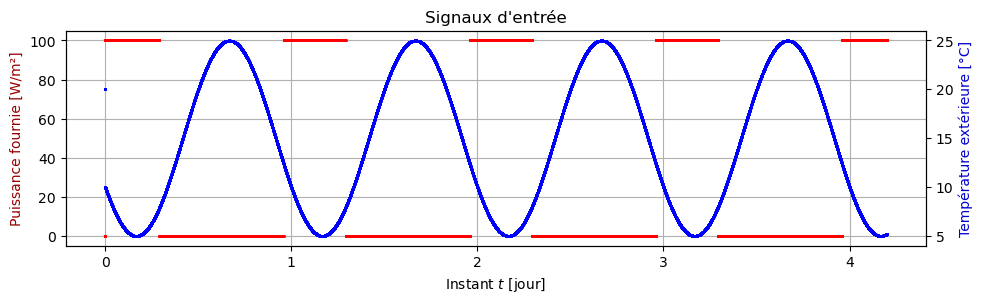

In [18]:
fig_in = plt.figure(figsize=(10,2.5))
ax_input = fig_in.subplots(1,1)
ax_input2 = ax_input.twinx()
ax_input.set_title("Signaux d'entrée")
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.07, top=0.93,
                    wspace=0.4, hspace=0.3)
ax_input.plot(t_en_jours, bicouche.signal("G"), ".r", markersize=2)
ax_input.set_ylabel("Puissance fournie [W/m²]", color=(0.6,0,0))
ax_input.grid()
ax_input2.plot(t_en_jours, bicouche.signal("D"), ".b", markersize=2)
ax_input2.set_ylabel("Température extérieure [°C]",color=(0,0,0.8))
ax_input.set_xlabel("Instant $t$ [jour]") ;

* Tracé des réponses calculées

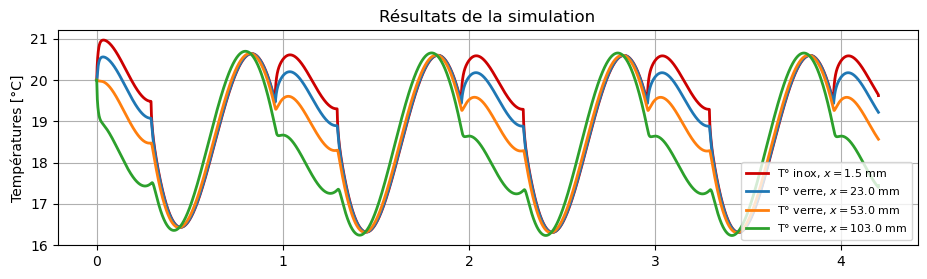

In [19]:
fig_out = plt.figure(figsize=(10,2.5))
ax_output = fig_out.subplots(1,1)
ax_output.set_title("Résultats de la simulation")
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.07, top=0.93,
                    wspace=0.4, hspace=0.3)
# Température au coeur de l'inox du socle
z_mil_inox = 0.5*inox.e # position du milieu de l'inox
             # aussi 0.5*(bicouche.X[0]+bicouche.X[1])
_,T_inox,_ = bicouche.T_phi(z_mil_inox)
ax_output.plot(t_en_jours, T_inox, "-", color=(0.8,0,0),
               linewidth=2.0,
               label = f"T° inox, $x={1e3*z_mil_inox:.1f}$ mm")
# Température du verre du côté extérieur
Vx = np.array([0.8*bicouche.X[1]+0.2*bicouche.X[2],
               0.5*bicouche.X[1]+0.5*bicouche.X[2], bicouche.X[2]])
for x in Vx :
    _,T_verre,_ = bicouche.T_phi(x)
    ax_output.plot(t_en_jours, T_verre, "-", linewidth=2.0,
                   label = f"T° verre, $x={1e3*x:.1f}$ mm")
# Finalisation du tracé
ax_output.set_ylabel("Températures [°C]")
ax_output.grid()
ax_output.legend(loc="best", fontsize=8) ;